In [48]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib
# matplotlib.use('PS')
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from numba import njit
from time import time
# Spline interpolation
from scipy.interpolate import RectBivariateSpline
# Multiprocessing:
from concurrent import futures as fut
from concurrent.futures import ProcessPoolExecutor, as_completed

from ipywidgets import FloatProgress
from IPython.display import display


In [49]:
import sys
# PATH = '$HOME/git/LCS/notebooks'
sys.path.insert(0, './utility/')
import importlib

In [50]:

factor = 10
NX = int(100*factor)
NY =  int(50*factor)
n = 8
num_lines_ = 5
smudge = 1.0

fig_s = (14, int(14 * NY / NX))

# print(fig_num)

In [51]:
##double gyre functions
import double_gyre
importlib.reload(double_gyre)#do a reload to set A and e properly
t_offset = 0
T0 = 0. + t_offset
TMAX = 20. + t_offset
A_ = 0.1
e_ = 0.35
h_=0.1
domain_len = 2
strain_res = 1*h_ / 100
spat_res = 0.2
fig_num = '_t%d-%de%0.2fA%0.2f_' % (T0, TMAX, e_, A_)
gyreObj = double_gyre
gyreObj.setGyreVars(A_, e_)
f = gyreObj.f
grid_of_particles = gyreObj.grid_of_particles
doublegyre = gyreObj.doublegyre
has_para = True

In [52]:
# ##norkyst 800 test
# import norkyst
# importlib.reload(norkyst)
# norkystObj = norkyst.norkystHandler()
# norkystObj(NX, NY)
# T0 = 0.
# t_offset = 0
# h_= norkystObj.time_res
# strain_res = 1.0*h_ / 100
# spat_res = norkystObj.x_res * 1.0
# TMAX = h_ * (norkystObj.dims[0]-2)
# fig_num = '_t%d-%d_' % (T0, TMAX)
# domain_len = max(norkystObj.x.values[-1] - norkystObj.x.values[0], norkystObj.y.values[-1] - norkystObj.y.values[0])
# domain_len = domain_len/10
# print('Orig data dims: ', norkyst.data.u.shape)
# print('Dimensions', norkystObj.dims)
# print('10/1.5 AB res: ', domain_len)
# print('Grid resolution: ',spat_res)
# has_para=False

# grid_of_particles = norkystObj.grid_of_particles
# f = norkystObj.f

In [53]:
#these should be put in another script

# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]

def rk4(X, t, h, f):
    k1 = f(X,          t)
    k2 = f(X + k1*h/2, t + h/2)
    k3 = f(X + k2*h/2, t + h/2)
    k4 = f(X + k3*h,   t + h)
    return X + h*(k1 + 2.*k2 + 2.*k3 + k4) / 6.


# Function to calculate endpoints from
# initial positions X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator

def endpoints(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = int((tmax - t) / h)
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
    
    while t < tmax:
        # Ensure we end up at correct time
        h = min(h, tmax - t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X

In [54]:
# Transport parameters
t0 = T0
tmax =  TMAX
h    =  h_

# Main grid initial points
Np   = NX*NY
X0m  = grid_of_particles(NX, NY, wx = 2.02, wy = 1.01)
Nx   = X0m.shape[1]
Ny   = X0m.shape[2]
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]

# Auxiliary grid initial points
dxa        = dxm / 100
dya        = dym / 100

n_p = int(n/2)
X0a        = np.empty((n, 2, 2, Nx, Ny))
X1a        = np.empty((n, 2, 2, Nx, Ny))

for i in range(0,n_p):
    X0a[i,0,:] = X0m + np.array([-dxa*(n_p - i), 0]).reshape(2,1,1)
for i in range(n_p, n):
    X0a[i,0,:] = X0m + np.array([dxa*(i+1 - n_p), 0]).reshape(2,1,1)
for i in range(0, n_p):
    X0a[i,1,:] = X0m + np.array([0, -dya*(n_p - i)]).reshape(2,1,1) 
for i in range(n_p, n):
    X0a[i,1,:] = X0m + np.array([0, dya*(i+1 - n_p)]).reshape(2,1,1)   
    
# X0a[0,0,:] = X0m + np.array([-dxa, 0]).reshape(2,1,1)
# X0a[1,0,:] = X0m + np.array([ dxa, 0]).reshape(2,1,1)
# X0a[0,1,:] = X0m + np.array([ 0,-dya]).reshape(2,1,1)
# X0a[1,1,:] = X0m + np.array([ 0, dya]).reshape(2,1,1)

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

# Progress bar
progressbar = FloatProgress(min = 0, max = 1+2*n_p)
display(progressbar)
futures = []
# Trajectory endpoints
if has_para:
    X1m   = endpoints(X0m, tmax, h, rk4, f, t=t0)
    progressbar.value += 1
    for i in range(n):
        X1a[i,0,:] = endpoints(X0a[i,0,:], tmax, h, rk4, f, t=t0)
        progressbar.value += 1
        X1a[i,1,:] = endpoints(X0a[i,1,:], tmax, h, rk4, f, t=t0)
        progressbar.value += 1
else:
    with ProcessPoolExecutor(9) as executor:
        futures.append(executor.submit(endpoints,
                                           X0m, tmax, h, rk4, f, t0))
        
        for i in range(n):
            futures.append(executor.submit(endpoints,
                                           X0a[i,0,:,:,:], tmax, h, rk4, f, t0))
        for i in range(n):
            futures.append(executor.submit(endpoints,
                                           X0a[i,1,:,:,:], tmax, h, rk4, f, t0))
    
    count = 0
#     fut.wait(return_when='ALL_COMPLETED')
    for p in (futures):
        progressbar.value += 1
        try:
            if count == 0:
                X1m = p.result()
            if count < n + 1:
                X1a[count - 1,0,:] = p.result()
#                 abc = p.result()
                count += 1
            else:
                X1a[count - n - 1,1,:] = p.result()
                count += 1
                
        except IndexError:
            pass
    
# print((abc))   
# X1a[0,0,:] = endpoints(X0a[0,0,:], tmax, h, rk4, f, t=t0)
# progressbar.value += 1
# X1a[1,0,:] = endpoints(X0a[1,0,:], tmax, h, rk4, f, t=t0)
# progressbar.value += 1
# X1a[0,1,:] = endpoints(X0a[0,1,:], tmax, h, rk4, f, t=t0)
# progressbar.value += 1
# X1a[1,1,:] = endpoints(X0a[1,1,:], tmax, h, rk4, f, t=t0)
# progressbar.value += 1

# Flow maps
FMm = X1m - X0m
FMa = X1a - X0a

# Save results to disk
np.save('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0m)
np.save('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0a)
np.save('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1m)
np.save('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1a)
np.save('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMm)
np.save('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMa)

In [55]:
Nx = NX
Ny =  NY
t0 = T0
tmax = TMAX

# Load data from disk
X0m = np.load('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0a = np.load('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1m = np.load('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1a = np.load('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMm = np.load('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMa = np.load('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0 = X0m
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]
# Grid parameter of auxiliary grid
dxa = X0m[0,0,0] - X0a[int(n/2) - 1,0,0,0,0]
dya = X0m[1,0,0] - X0a[int(n/2) - 1,1,1,0,0]

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

Main grid consists of 1000 x 500 = 500000 points.
Corners:  (-0.010000000000000009, -0.0050000000000000044) (2.01, 1.005)
dxm =  0.0020220220220220214 dym =  0.0020240480961923844
dxa =  2.0220220220220145e-05 dya =  2.0240480961923428e-05


In [56]:
def dFMm_t0_t(x_):
    dFMm = np.ones((Nx, Ny, 2, 2))
    #### Derivatives for original array ####
    # dFMm_x/dx
    dFMm[1:-1, :  ,0,0] = (   x_[0,2:  , :  ] -   x_[0, :-2, :  ] )                     / (2*dxm) # Central finite difference
    dFMm[   0, :  ,0,0] = ( 4*x_[0,   1, :  ] - 3*x_[0,   0, :  ] - 2*x_[0,   2, :  ]) / (2*dxm)  # One-sided finite difference
    dFMm[  -1, :  ,0,0] = ( 3*x_[0,  -1, :  ] - 4*x_[0,  -2, :  ] + 2*x_[0,  -3, :  ]) / (2*dxm)  # One-sided finite difference
    # dFMm_x/dy
    dFMm[ :  ,1:-1,0,1] = (   x_[0, :  , 2: ] -   x_[0, :  , :-2] )                     / (2*dym) # Central finite difference
    dFMm[ :  ,   0,0,1] = ( 4*x_[0, :  ,   1] - 3*x_[0, :  ,   0] - 2*x_[0, :  ,   2]) / (2*dym)  # One-sided finite difference
    dFMm[ :  ,  -1,0,1] = ( 3*x_[0, :  ,  -1] - 4*x_[0, :  ,  -2] + 2*x_[0, :  ,  -3]) / (2*dym)  # One-sided finite difference
    # dFMm_y/dx
    dFMm[1:-1, :  ,1,0] = (   x_[1,2:  , :  ] -   x_[1, :-2, :  ] )                     / (2*dxm) # Central finite difference
    dFMm[   0, :  ,1,0] = ( 4*x_[1,   1, :  ] - 3*x_[1,   0, :  ] - 2*x_[1,   2, :  ]) / (2*dxm)  # One-sided finite difference
    dFMm[  -1, :  ,1,0] = ( 3*x_[1,  -1, :  ] - 4*x_[1,  -2, :  ] + 2*x_[1,  -3, :  ]) / (2*dxm)  # One-sided finite difference
    # dFMm_y/dy
    dFMm[ :  ,1:-1,1,1] = (   x_[1, :  , 2: ] -   x_[1, :  , :-2] )                      / (2*dym) # Central finite difference
    dFMm[ :  ,   0,1,1] = ( 4*x_[1, :  ,   1] - 3*x_[1, :  ,   0] - 2*x_[1, :  ,   2] ) / (2*dym)  # One-sided finite difference
    dFMm[ :  ,  -1,1,1] = ( 3*x_[1, :  ,  -1] - 4*x_[1, :  ,  -2] + 2*x_[1, :  ,   -3]) / (2*dym)  # One-sided finite difference
    return dFMm
def dFMa_t0_t(x_):
    dFMa = np.ones((Nx, Ny, 2, 2))
    #### Derivatives for auxiliary array ####
    # dx/dx
    #FMa -> X1a
    dFMa[:,:,0,0] = ( X1a[int(n/2) - 1,0,0,:,:] - X1a[int(n/2),0,0,:,:] ) / (2*dxa) # Central finite difference
    # dx/dy
    dFMa[:,:,0,1] = ( X1a[int(n/2) - 1,1,0,:,:] - X1a[int(n/2),1,0,:,:] ) / (2*dya) # Central finite difference
    # dx/dx
    dFMa[:,:,1,0] = ( X1a[int(n/2) - 1,0,1,:,:] - X1a[int(n/2),0,1,:,:] ) / (2*dxa) # Central finite difference
    # dx/dy
    dFMa[:,:,1,1] = ( X1a[int(n/2) - 1,1,1,:,:] - X1a[int(n/2),1,1,:,:] ) / (2*dya) # Central finite difference
    return dFMa

In [57]:
# Arrays to hold derivatives for original array and auxiliary array
dFMm = np.ones((Nx, Ny, 2, 2))
dFMa = np.ones((Nx, Ny, 2, 2))

dFMm = dFMm_t0_t(X1m)
dFMa = dFMa_t0_t(X1a)
CGm = np.matmul(np.transpose(dFMm, axes = (0,1,3,2)), dFMm)
CGa = np.matmul(np.transpose(dFMa, axes = (0,1,3,2)), dFMa)

vals_m, vecs_m = np.linalg.eigh(CGm)
vals_a, vecs_a = np.linalg.eigh(CGa)
# Store values and vectors separately for less indexing hassle
lmbd1_ = vals_m[:,:,0]
lmbd2_ = vals_m[:,:,1]
xi1_     = vecs_a[:,:,:,0]
xi2_     = vecs_a[:,:,:,1]

In [58]:
xi2_.shape

(1000, 500, 2)

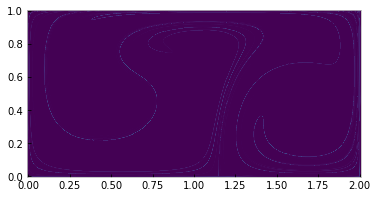

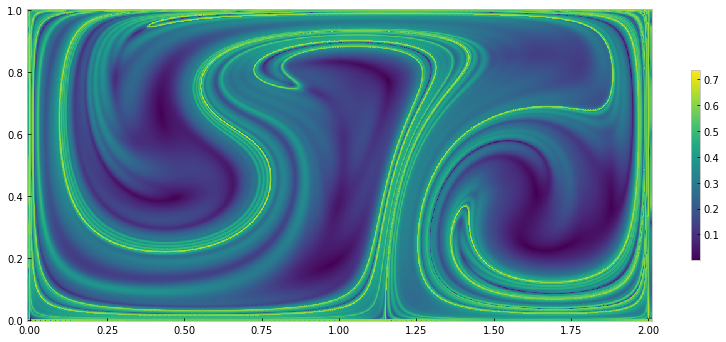

In [59]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, aspect = 'equal')

mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], lmbd2_)
# plt.colorbar(mesh, shrink = 0.6)
# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)


fig = plt.figure(figsize = fig_s)
ax = fig.add_subplot(111, aspect = 'equal')
mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(lmbd2_)/(1*tmax))
plt.colorbar(mesh, shrink = 0.5)
plt.savefig('out/ftle_field' + fig_num + '.png', dpi=400)
# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)

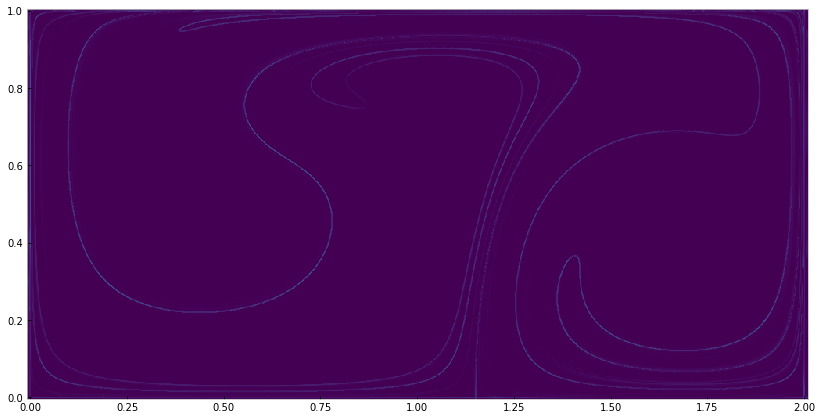

In [60]:
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(111, aspect = 'equal')

mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], lmbd2_)

In [61]:
Atol = 0.0
Atrue = np.logical_and(np.abs(lmbd1_ - lmbd2_) > Atol, lmbd2_ - 1. > Atol)
#Atrue = np.logical_and(lambda2 == lambda2, lambda2 == lambda2)
print('Number of points where A is true: ', np.sum(Atrue))



lmbd = lmbd2_.reshape((Nx,Ny))
    
hessian = np.zeros((Nx,Ny,2,2))
    
# First, the laplacian terms:
    
# Internal points: Centered differences
hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dxm**2)
hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dym**2)
    
    # Near boundaries: Higher order forwards/backwards differences
hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dxm**2)
hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dxm**2)
    
hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dym**2)
hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dym**2)

# Then, the mixed derivatives:
dldx = np.empty((Nx,Ny))
dldy = np.empty((Nx,Ny))

# Internal points: Centered differences
dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dxm)
dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dxm)
dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dxm)

dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dym)
dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dym)



# Same deal for the mixed derivatives
d2ldxdy = np.empty((Nx,Ny))
d2ldydx = np.empty((Nx,Ny))

# Internal points: Centered differences
d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dxm)
d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dxm)
d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dxm)

d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dym)
d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dym)

hessian[:,:,0,1] = d2ldxdy
hessian[:,:,1,0] = d2ldydx

hessian = hessian[:,:,:,:].reshape(((Nx)*(Ny), 2, 2))
xi2_m = xi2_.reshape((Nx*Ny), 2)
# Taking inner product, although it seems useless
#inner   = np.sum(xi1 * (hessian)[:,:,0] * xi1, axis = -1)
inner = np.sum(xi2_m * np.sum(hessian*xi2_m[...,np.newaxis], axis=1), axis=1)
Btol = 0.0
inner = inner.reshape((Nx,Ny))
Btrue   = inner  <= Btol
print('Number of points where B is true: ', np.sum(Btrue))

ABtrue_ = np.logical_and(Atrue, Btrue)

print('Number of points where A and B is true: ', np.sum(ABtrue_))

Number of points where A is true:  500000
Number of points where B is true:  149630
Number of points where A and B is true:  149630


In [62]:
# 1D-arrays of grid coordinates for convenience
xc_ = X0m[0,:,0]
yc_ = X0m[1,0,:]
nx_ = Nx
ny_ = Ny
dx = dxm
dy = dym
gridx, gridy = np.meshgrid(xc_, yc_)
grid = np.array([gridx.T, gridy.T]).reshape(2, nx_*ny_)

xc = np.concatenate((-dx * np.arange(1, n+1)[::-1] + xc_[0], xc_, dx*np.arange(1, n+1) + xc_[-1]))
yc = np.concatenate((-dy * np.arange(1, n+1)[::-1] + yc_[0], yc_, dy*np.arange(1, n+1) + yc_[-1]))

xi1 = np.zeros((nx_ + 2*n, ny_ + 2*n, 2))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        xi1[i,j,:] = xi1_[i_,j_,:]

xi2 = np.zeros((nx_ + 2*n, ny_ + 2*n, 2))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        xi2[i,j,:] = xi2_[i_,j_,:]

lmbd2 = np.zeros((nx_ + 2*n, ny_ + 2*n))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        lmbd2[i,j] = lmbd2_[i_,j_]

lmbd1 = np.zeros((nx_ + 2*n, ny_ + 2*n))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        lmbd1[i,j] = lmbd1_[i_,j_]
        
ABtrue = np.ones((nx_ + 2*n, ny_ + 2*n), dtype = np.bool)
ABtrue[n:n+nx_, n:n+ny_] = ABtrue_

nx = xi1.shape[0]
ny = xi1.shape[1]

(-1150000, -1200000)

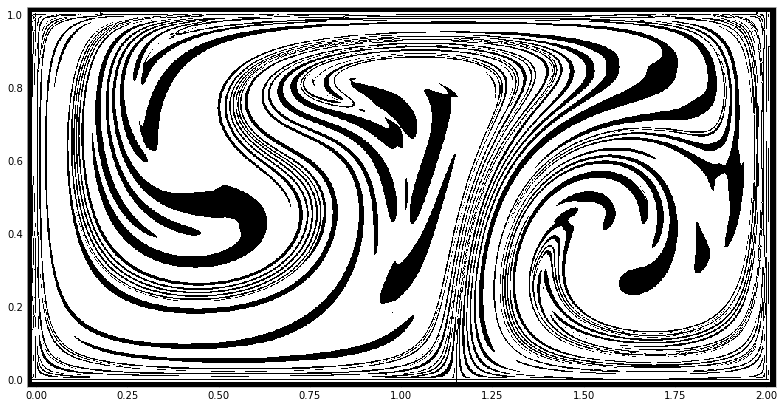

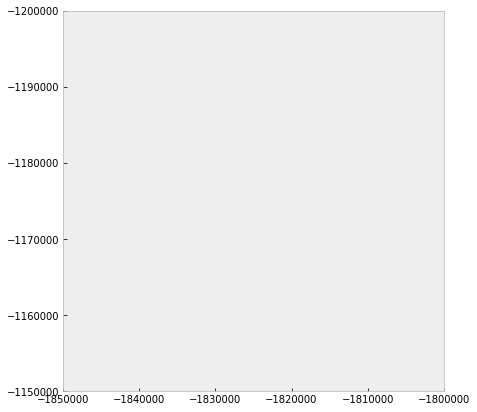

In [63]:
from scipy.ndimage.filters import gaussian_filter
# ABtrue = gaussian_filter(ABtrue.astype(np.float32), .125*NX/1000)
# ABtrue = (np.ceil(ABtrue)).astype(np.int32)


fig = plt.figure(figsize = fig_s)
ax = fig.add_subplot(111, aspect = 'equal')
plt.pcolormesh(xc, yc, ABtrue.T, cmap = plt.get_cmap('Greys'))
plt.savefig('out/ab_dom' + fig_num + '.png')


fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(111, aspect = 'equal')
plt.pcolormesh(xc, yc, ABtrue.T, cmap = plt.get_cmap('Greys'))

plt.xlim([-1850000, -1800000])
plt.ylim([-1150000, -1200000])
# fig = plt.figure(figsize = fig_s)
# plt.scatter(X0m[0,ABtrue],X0m[1,ABtrue],s=1,marker='.',c='tomato')

In [64]:
# fig = plt.figure(figsize=(10,10))

# plt.pcolormesh(xi1[:,:,0].T)
# # plt.xlim([430, 450])
# # plt.ylim([200, 300])

# fig = plt.figure(figsize=(10,10))

# plt.pcolormesh(xi2[:,:,0].T)
# plt.savefig('egeinfield_%1.5f_.png' % dxa)
# # fig = plt.figure(figsize=(10,10))

# # plt.pcolormesh(median_filter(xi2[:,:,0],3))
# # print(xi1[435:440, 200,0])

In [65]:
mask = np.zeros((Nx + 2*n, Ny + 2*n), dtype = np.bool)
lines = num_lines_ - 0
fig_num += '_lin-' + str(lines - 1)
for i in range(1,lines):
    mask[:,min( int(i*(Ny+1*n)/lines), Ny-1)] = True
    mask[min( int(i*(Nx+1*n)/lines), Nx-1),:] = True

XC, YC = np.meshgrid(xc, yc)  
    
Gx = XC.T[np.logical_and(mask, ABtrue)]
Gy = YC.T[np.logical_and(mask, ABtrue)]

G = np.array([Gx, Gy])

print('G has %s points' % G.shape[1])

G has 1701 points


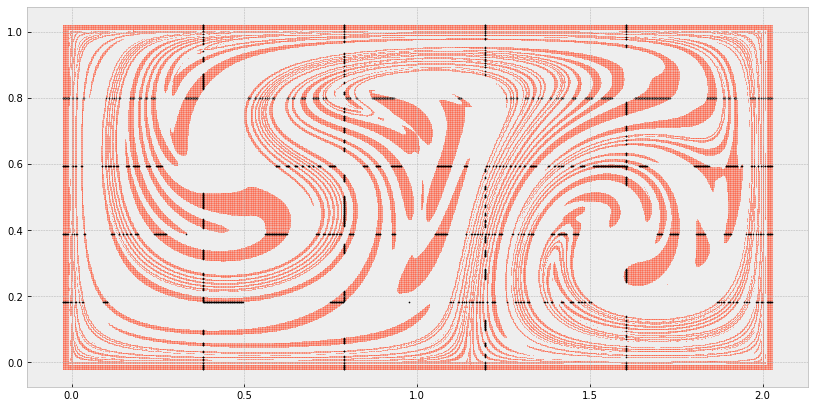

In [66]:
fig = plt.figure(figsize=fig_s)
plt.scatter(XC[ABtrue.T], YC[ABtrue.T],s=1,marker='.',c='tomato', alpha=0.5)
plt.scatter(G[0,:], G[1,:], marker = '.', c = 'k', lw = 0.5, s = 5)
# plt.xlim([1.25, 1.5])
# plt.ylim([0.6, 0.8])
plt.savefig('out/G' + fig_num + '.png')

In [67]:
print(X0m.shape)
print(np.array([XC,YC]).shape)

(2, 1000, 500)
(2, 516, 1016)


In [68]:
import cub_strain as c_s
importlib.reload(c_s)
c_s.setNXNY(Nx, Ny, n)

GRID = np.array([XC,YC])

EigVec = np.zeros((2, 2, xi1.shape[0], xi1.shape[1]))
EigVec[:, 0, :, :] = np.rollaxis(xi1, 2, 0)
EigVec[:, 1, :, :] = np.rollaxis(xi2, 2, 0)


EigVal = np.zeros((2, lmbd2.shape[0], lmbd2.shape[1]))
EigVal[0, :, :] = lmbd1
EigVal[1, :, :] = lmbd2

f_xi = c_s.CubicSpecial(xc, yc, EigVec[:,0,:,:], n)

lmdd1 = RectBivariateSpline(xc, yc, lmbd1, kx=3, ky=3)
lmdd2 = RectBivariateSpline(xc, yc, lmbd2, kx=3, ky=3)
lambdas = np.array([lmdd1, lmdd2])

# List to hold strainlines and associated parameters
# (number not known ahead of time, hence lists)
strainlines   = []
lengths       = []
lengths_notAB = []
eigvals_mean  = []

# Filtering parameters
max_notAB  = 1.5*domain_len / 10
min_length = 500*strain_res
# Trajectory integration parameters
# Note: "Speed" is 1 everywhere, since eigenvectors
# are normalised. Thus Tmax gives max length directly
Tmax = 1.1*strain_res*1e4
h    = 3 * strain_res

t_start = time()
progressbar = FloatProgress(min=0, max=100)
display(progressbar)
futures = []
count = 0
with ProcessPoolExecutor(11) as executor:
    for i in range(G.shape[1]):
        count += 1
        if count % int(G.shape[1]/100) == 0: progressbar.value += 1
        futures.append(executor.submit(c_s.strainline, G[:,i], Tmax, h,\
                                       f_xi, xc, yc, lambdas, ABtrue,grid.reshape(2, nx_, ny_),\
                                       max_notAB = max_notAB))
    

progressbar = FloatProgress(min=0, max=100)
display(progressbar)
count = 0
for p in as_completed(futures):
    count += 1
    if count % int(G.shape[1]/100) == 0:
        progressbar.value += 1
    try:
        line, length, eigval_mean = p.result()
        if length > min_length:
            strainlines.append(line)
            lengths.append(length)
            eigvals_mean.append(eigval_mean)
    except IndexError:
        pass

print('Identified %s LCS candidates' % len(strainlines))

lengths = np.array(lengths)
eigvals_mean = np.array(eigvals_mean)


t_end = time()
print('In only %d min and %d sec' % (int((t_end - t_start)/60), t_end - t_start - 60*(int((t_end - t_start)/60))))

FloatProgress(value=0.0)

FloatProgress(value=0.0)

Identified 1586 LCS candidates
In only 3 min and 56 sec


In [69]:
# 1D-arrays of grid coordinates for convenience
xc_ = X0m[0,:,0]
yc_ = X0m[1,0,:]
dx =  xc[1] - xc[0]
dy = yc[1] - yc[0]

inside_eigvals  = []
running_eigvals = []
running_ABtrues = []

progressbar = FloatProgress(min=0, max=len(strainlines))
display(progressbar)

fLCSs = strainlines
flengths = lengths

for i in range(len(strainlines)):
    progressbar.value += 1
    eigvals = np.zeros(strainlines[i].shape[1])
    ABtrues = np.zeros(strainlines[i].shape[1], dtype = np.bool)
    for n in range(strainlines[i].shape[1]):
        igrid = np.floor(((strainlines[i][0,n]+dx/2) - xc_[0]) / dx).astype(np.int32)
        jgrid = np.floor(((strainlines[i][1,n]+dy/2) - yc_[0]) / dy).astype(np.int32)
        if ABtrue[igrid, jgrid]:
            ABtrues[n] = True
            eigvals[n] = EigVal[1,igrid,jgrid]
    inside_eigvals.append(np.sum(eigvals[ABtrues]) / np.sum(ABtrues))
    running_eigvals.append(eigvals)
    running_ABtrues.append(ABtrues)

FloatProgress(value=0.0, max=1586.0)

/home/and/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


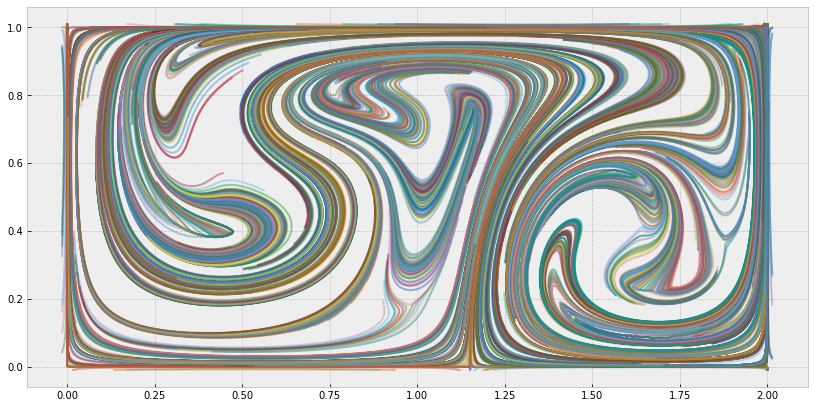

In [70]:
fig = plt.figure(figsize=fig_s)
for i in range(len(strainlines)):
    plt.plot(strainlines[i][0,:], strainlines[i][1,:], alpha=0.4)
plt.savefig(strain_path + '/cool_strainlines' + fig_num + '.png')

In [71]:
#temps

temp_flcs = fLCSs
temp_lens = flengths
temp_eigs = eigvals_mean
print(len(flengths))

1586


In [72]:
fLCSs = temp_flcs
flengths = temp_lens
eigvals_mean = temp_eigs

In [73]:
#removing shorter lines
mult = 0.1
while(len(fLCSs) > 1200):
    
    new_lines = []
    new_lens = []
    new_eigs_mean = []
    maks = np.max(flengths)
    for i in range(len(fLCSs)):
        if flengths[i] > mult*maks:
            new_lines.append(fLCSs[i])
            new_lens.append(flengths[i])
            new_eigs_mean.append(eigvals_mean[i])
    fLCSs = new_lines
    flengths = new_lens
    eigvals_mean = new_eigs_mean
    print(len(fLCSs))
    mult += mult/10
print(mult*maks)

1390
1353
1319
1251
1097
2.7700318595962115


In [74]:
# start variables:
# search through longest array and find if shortest starts and ends somewhere on the longest line

# should be possible to iterate through both these lines the same way because the step is the same
# thus if they follow eachother - > should work

# dist = (fLCSs[i][j + start_i,0] - fLCSs[k][j + start_k,0])**2 + (fLCSs[i][j + start_i,1] - fLCSs[k][j + start_k,1])**2
# dist = np.sqrt(dist)

def searcher(short_line, long_line, epsilon):
    tol = 0.3
    if len(short_line[0,:]) > len(long_line[0,:]): 
        print('one faulty boi')
        return -1, -1
    x0, y0 = short_line[:,  0]
    x1, y1 = short_line[:, -1]
    u0, v0 = long_line[:,   0]
    u1, v1 = long_line[:,  -1]
    start = -1
    end = -1
    short = 1 # bool for checking which line to start with
    len_s = len(short_line[0,:])
    len_l = len(long_line[ 0,:])
    #check if short line starts on the long one
    dists = np.sqrt((long_line[0,:] - x0)**2 + (long_line[1,:] - y0)**2)
    start = np.argmin(dists)
    if dists[start] < epsilon:

        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end-start) > tol * len_s:
                return start, end, short
            else:
                return start, -1, short
        
        dists = np.sqrt((short_line[0,:] - u1)**2 + (short_line[1,:] - v1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end) > tol * len_s:
                return start, len_l - start - 1, short
            else:
                return -1, -1, short
        else:
            return start, -1, short

    else: #if short line dont start on the long line -> check other way around
        short = 0
        dists = np.sqrt((short_line[0,:] - u0)**2 + (short_line[1,:] - v0)**2)
        start = np.argmin(dists)
        if dists[start] > epsilon:
            return -1, -1, short
        
        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] > 1*epsilon:
            return start, -1, short
        else:
            if (len_s - start) > tol * len_s:

                return start, len_s - start - 1, short
            else: 

                return -1, -1, short

    return start, end, short
        
        
       
        
    

#inner_loop funk


def inner_looper(fLCSs, i, epsilon):
#     print(fLCSs)
    dist = np.zeros(len(fLCSs))
    for j in range(len(fLCSs)):
        if i == j: continue
        len_i = len(fLCSs[i][0,:])
        len_j = len(fLCSs[j][0,:])
        len_short = 0
        length = 0
        end = 0
        start = 0
        nul_val = 1e2
        correction = 0
        if len_j > len_i:
            start, end, order = searcher(fLCSs[i], fLCSs[j], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp

            len_short = end - start

            
            if order:
                start_iter_j = start
                start_iter_i = 0
            else:
                start_iter_i = start
                start_iter_j = 0
            if len_short > len(fLCSs[i][0,:]):
                correction = len_short-len(fLCSs[i][0,:])   
        else:
            start, end, order = searcher(fLCSs[j], fLCSs[i], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp

            len_short = end - start
            
    
            
        
            if order:
                start_iter_j = 0
                start_iter_i = start
            else:
                start_iter_i = 0
                start_iter_j = start
            if len_short > len(fLCSs[j][0,:]):
                correction = len_short-len(fLCSs[j][0,:]) 

                
        
        
        
        
        if end == -1 or start_iter_i == -1 or start_iter_j == -1:
            dist[j] = nul_val
            continue


        distances = np.zeros(len_short)

        len_short -= correction
        if len_short < 1:
            dist[j] = nul_val
            continue
        len_ii = start_iter_i + len_short
        len_jj = start_iter_j + len_short
        
        

        distances = np.sqrt((fLCSs[i][0,start_iter_i:len_ii] - fLCSs[j][0, start_iter_j:len_jj])**2 \
                        + (fLCSs[i][1,start_iter_i:len_ii] - fLCSs[j][1, start_iter_j:len_jj])**2)
        if len_i < len_j:
            x_diff = fLCSs[i][0,start_iter_i + 1:len_ii] - fLCSs[i][0,start_iter_i:len_ii - 1]
            y_diff = fLCSs[i][1,start_iter_i + 1:len_ii] - fLCSs[i][1,start_iter_i:len_ii - 1]
        else:
            x_diff = fLCSs[j][0,start_iter_j + 1:len_jj] - fLCSs[j][0,start_iter_j:len_jj - 1]
            y_diff = fLCSs[j][1,start_iter_j + 1:len_jj] - fLCSs[j][1,start_iter_j:len_jj - 1]
        length = np.sum(np.sqrt(x_diff**2 + y_diff**2))
        dist[j] = np.sum((distances))
        dist[j] = dist[j] / (length * 1)
        
    return dist

# normalize over length of shortest line
   


In [75]:
# flengths,fLCSs, eigvals_mean = (zip(*sorted(list(zip(flengths, fLCSs, eigvals_mean)))))

# import random
# fLCSs = strainlines

# # fig_num = '2'
# c = list(zip(fLCSs, flengths, eigvals_mean))
# #andom.shuffle(c)
# fLCSs, flengths, eigvals_mean = zip(*c)
# #print(fLCSs[0])

nearest_nbs = np.zeros((len(fLCSs), len(fLCSs)))
nearest_nbs.shape
print(fLCSs[0].shape)
epsilon = domain_len / 1

# Progress bar
progressbar = FloatProgress(min = 0, max = int(len(fLCSs) / 20))
display(progressbar)

#first loop: iterate over all lines
##IS THIS SYMMETRIC? problem size could possibly be reduced by factor 2 
short_fLCSs = []
for i in range(len(fLCSs)):
    line = fLCSs[i][:,::4]
    short_fLCSs.append(line)
for i in range(len(fLCSs)):
        nearest_nbs[i,:] = inner_looper(short_fLCSs, i, epsilon)
        if i % 20 == 0: progressbar.value += 1

(2, 1854)


FloatProgress(value=0.0, max=54.0)

In [76]:
# np.where(nearest_nbs > 1e3)

In [77]:
# nearest_nbs[1, 921]

In [78]:
nearest_nbs = np.where(np.isnan(nearest_nbs), 1e2, nearest_nbs)
nearest_nbs_test = np.where(nearest_nbs == 0, 1, nearest_nbs)
nearest_nbs_inv = np.where(nearest_nbs != 0, np.divide(1, nearest_nbs), 1)
mult = .5
NEAREST = np.where(nearest_nbs_inv > 0, 1, 0)


/home/and/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


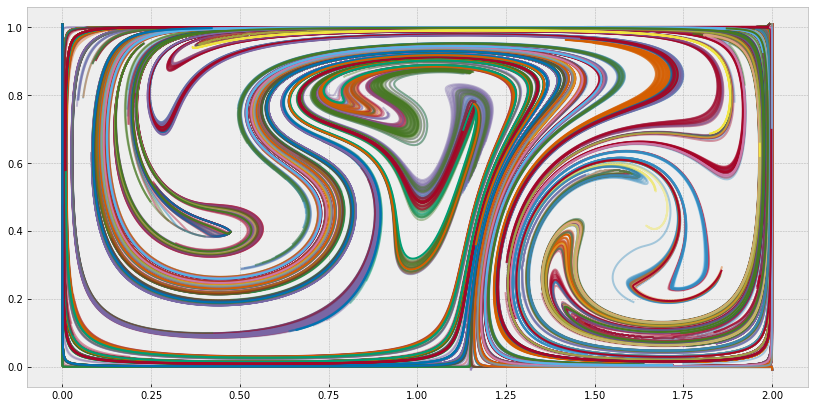

In [79]:
fig = plt.figure(figsize=fig_s)

plotted = set([])
mult = .01
   



for i in range(len(fLCSs)):
    if i not in plotted:
        line1 = fLCSs[i]
        I, = plt.plot(line1[0,:], line1[1,:])
        plotted.add(i)
        threshold = mult#*np.mean(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        for j in range(len(fLCSs)):
            if j not in plotted:
                if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                    line2 = fLCSs[j]
                    plt.plot(line2[0,:], line2[1,:], c = I.get_color(), alpha=0.4)
                    plotted.add(j)
# plt.savefig('out/neighbours' + fig_num +'.png')
plt.show()

In [80]:
# fig = plt.figure(figsize=fig_s)
# for i in range(21, 22):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], alpha=0.8)
# plt.show()
# print(fLCSs[i][0,:])
# for j in range(alen(fLCSs[i][0,:])):
#     print('x: %0.5f, y: %0.5f' % (fLCSs[i][0,j], fLCSs[i][1,j]))

In [81]:
# %matplotlib notebook

[   0  105  112  115  147  149  164  216  332  437  499  514  572  575
  576  579  581  639  641  644  647  649  651  749  816  831  904  909
  960 1050 1068]
0.05


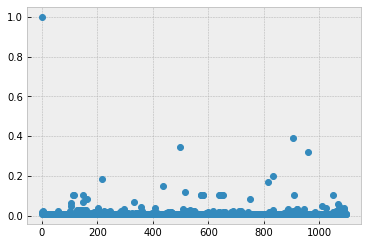

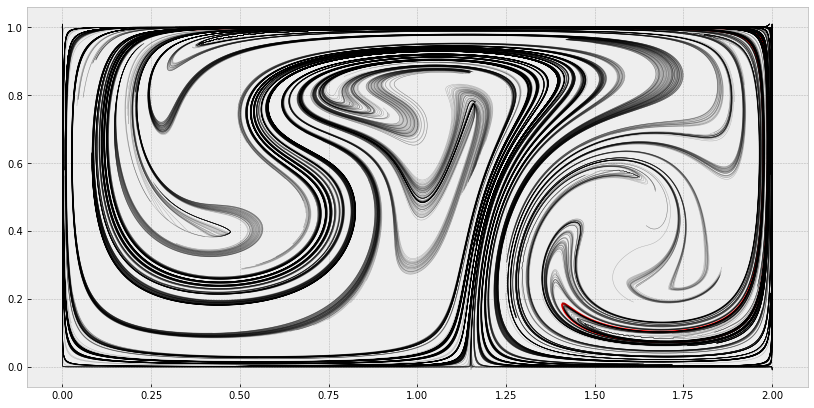

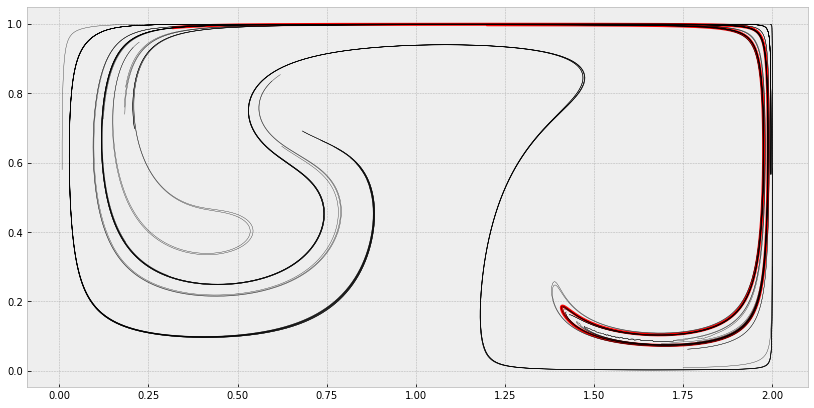

In [82]:
num =0
mult = 5e-2
   
threshold = 1*mult#*np.mean(nearest_nbs_inv[num,np.where(nearest_nbs_inv[num,:] > 0 )])



plt.plot(np.linspace(0,nearest_nbs.shape[0], nearest_nbs.shape[0]),nearest_nbs_inv[num,:],'o')
#pick closest lines
friendsof_num = np.where(nearest_nbs_inv[num,:] > threshold )
friendsof_num[0]
fig = plt.figure(figsize=fig_s)
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 2)
for i in range(len(fLCSs)):
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 0.5, alpha=0.25 )
    
alphas = np.exp(nearest_nbs_inv[num,friendsof_num[0]])
alphas = np.sqrt(alphas / np.max(alphas))

#plot to see if it makes sense
fig = plt.figure(figsize=fig_s)
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 3 )
count = 0
for i in set(friendsof_num[0]):
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = alphas[count] * .5, alpha=1)
    count+=1
    
print(friendsof_num[0])
print(threshold)
# alphas

In [83]:
# fLCSs = strainlines
minn = len(fLCSs[0][0,:])
maxx = 0
for i in range(len(fLCSs)):
    if(len(fLCSs[i][0,:]) < minn):
        minn = len(fLCSs[i][0,])
    if(len(fLCSs[i][0,:]) > maxx):
        maxx = len(fLCSs[i][0,])

print('max length of LCS: %d' % maxx)
print('min length of LCS: %d' % minn)

max length of LCS: 6435
min length of LCS: 842


In [84]:
ABtrue = ABtrue_
lambda2 = lmbd2_

In [85]:
from scipy.interpolate import UnivariateSpline, interp1d
divider = 5
size = int(maxx/divider)
X = np.zeros((len(fLCSs), size))
y = np.zeros((len(fLCSs), size))
eigs = np.zeros((len(fLCSs), size))
for i in range(len(fLCSs)):
    leng = int(len(fLCSs[i][0,]))
    x_diff = np.zeros(leng)
    y_diff = np.zeros(leng)
    x_diff[1:-1] = fLCSs[i][0,1:-1] - fLCSs[i][0,0:-2]
    y_diff[1:-1] = fLCSs[i][1,1:-1] - fLCSs[i][1,0:-2]
    
    xs = np.cumsum(np.sqrt(x_diff**2 + y_diff**2))
    xs = xs / xs[-1]
#     xs = xs[::divider]
#     print(xs)
    spline_x = interp1d(x=xs, y=fLCSs[i][0,])
    spline_y = interp1d(x=xs, y=fLCSs[i][1,])
    x_long = np.linspace(0, 1, size)
    X[i,:] = spline_x(x_long)
    y[i,:] = spline_y(x_long)
    
#     ratio = 1 - len(fLCSs[i][0,:]) / size
#     multiplier = int(len(fLCSs[i][0,:]) / size)
#     offset = 0


#     for j in range(size):#len(fLCSs[i][0,:])):
        
#         X[i, j + offset] = fLCSs[i][0, j * multiplier]
#         y[i, j + offset] = fLCSs[i][1, j * multiplier]



In [86]:
import os
from os import path

strain_path = 'strainlines-AB{:1.2f}-h{:1.3f}-nx{:d}-ny{:d}'.format(max_notAB, h, Nx, Ny)

if not os.path.exists(strain_path):
        os.mkdir(strain_path)
np.save(strain_path + '/strainlines.npy', np.array([X, y]))
np.save(strain_path + '/flengths.npy', flengths)
np.save(strain_path + '/eigvals_mean.npy', eigvals_mean)
np.save(strain_path + '/lambda2.npy', lambda2)
np.save(strain_path + '/ABtrue.npy', ABtrue)
np.save(strain_path + '/nearest_nbs.npy', nearest_nbs)
np.save(strain_path + '/figure_name.npy', fig_num)

In [87]:
# plt.plot(xs[::50],'.')

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn import datasets, cluster
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
 

n_comps = 10
# kpca0 = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=n_comps)
kpca1 = KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=n_comps)
# kpca2 = KernelPCA(kernel="linear", fit_inverse_transform=True, n_components=n_comps)
# kpca3 = KernelPCA(kernel="poly", fit_inverse_transform=True, n_components=n_comps*10)
# X_kpca0 = kpca0.fit_transform(X, y)
# X_kpca0 = kpca0.fit_transform(X_kpca0, nearest_nbs)

X_kpca1 = kpca1.fit_transform(X, y)
X_kpca1 = kpca1.fit_transform(X_kpca1, nearest_nbs)

# X_kpca2 = kpca2.fit_transform(X, y)
# X_kpca2 = kpca2.fit_transform(X_kpca2, nearest_nbs_inv)

# X_kpca3 = kpca3.fit_transform(X, y)
#X_kpca3 = kpca3.fit_transform(X_kpca3, nearest_nbs_inv)
#NEIGH_feats = kpca0.fit_transform(nearest_nbs)
print('done')


In [ ]:
# fig = plt.figure(figsize=fig_s)
# # for i in range(len(X[:,0])):
# for i in range(15,20):
#     plt.plot(X[i,::20], y[i,::20], alpha=0.9, marker='.')

In [ ]:
X_new = X_kpca1[:,0::]
for i in range(X_new.shape[1]):
    X_new[:,i] = X_new[:,i] / np.std(X_new[:,i])
#X_kpca = kpca1.fit_transform(X_kpca, nearest_nbs)
print(X_new.shape)
# #fig = plt.figure(figsize=(16,8))
# plt.scatter(X_kpca[:,0], X_kpca[:,1])
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs=X_new[:,0], ys=X_new[:,1], zs=X_new[:,2], zdir='z')


X_new = X_new#[:, ::1]
#print(X_new[:,0])
# fig = plt.figure(figsize=(16,8))
#plt.scatter(X_new[:,0], X_new[:,1], color = 'k')
print(X_new.shape)


In [ ]:
def find_max_lcss(fLCSs, n_clusters_, labels, flen, flambs):
    num_clust = n_clusters_

    #flengths
    #eigvals_mean

    #array for holding the selected LCSs
    chosen_LCS = []
    #find which lines belong to a cluster
    
    
    ####need to fix here for second run -- cant multiply by step and expect correct indices. mapping?
    len_min = 1.0
    for k in range(num_clust):
        #print("cluster %d  " %k)
        my_members = labels == k
        if(my_members.size == 1): continue
        indices = np.where(my_members)
        local_lines = []
        if (len(indices[0]) < 3 or indices[0] is None):
            continue
        for i in range(len(indices)):

            local_lines.append(indices[0][i])
    
        #local_lines = indices

        ind = 0
        identity = -1
        maxi_lamb = 0
        maxi_len = 0
        leng = len(local_lines)
        #print(local_lines)
        for i in set(local_lines):
            if flengths[i] > len_min:
                if eigvals_mean[i] > maxi_lamb:
                #if flengths[i] > flengths[identity]:# and (np.abs(eigvals_mean[i] - maxi_lamb) < 1e-1 or eigvals_mean[i] > maxi_lamb):
                    identity = i
                    maxi_lamb = eigvals_mean[i]
                    maxi_len = flengths[i] 
                else:
                    if eigvals_mean[i] == maxi_lamb and flengths[i] > maxi_len:
                        identity = i
                        maxi_len = flengths[i]
                        maxi_lamb = eigvals_mean[i]
        if identity not in chosen_LCS and identity != -1: chosen_LCS.append(identity)
        #print("identity: %d \n" % identity)

    print(chosen_LCS)

    return chosen_LCS

In [ ]:
def cherryPicker(chosen_LCS, flambs, nearest_nbs_inv, epsilon, mult=1):
    count = len(chosen_LCS)
    num_lines = len(nearest_nbs_inv[0,:])
    new_chosen = []
    for i in set(chosen_LCS):
        #trying mean rather than median
        threshold = 50*mult#np.mean(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        similars = []
        similars.append(i)
        for j in set(chosen_LCS):
            if i == j: continue
            if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                similars.append(j)
        line = i
        for k in range(len(similars)):
            if flambs[i] < flambs[similars[k]]:
                line = similars[k]
        #try to weed out the weak
        for o in set(similars):
            if o in new_chosen:# and np.abs(flengths[o] - flengths[line]) > 0.7*max(flengths[o], flengths[line]):
                new_chosen.remove(o)
        
        if line not in new_chosen:
            new_chosen.append(line)
    return new_chosen

In [ ]:
# for i in range(len(X)):
#     plt.plot(X[i,:], y[i,:])

In [ ]:
from sklearn.cluster import DBSCAN
X_ = X_new

# extra = 0 if  X.shape[1] % 4 == 0 else 1
# X_ = np.empty((X.shape[0], 2, int(X.shape[1]/4) + extra))

# X_[:,0,:] = X[:,::4]
# X_[:,1,:] = y[:,::4]

epsil0 = (np.amax(X_) - np.amin(X_)) / 3
print(epsil0)
epsil = epsil0
_clust = 30
samps = 4
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps).fit(X_)#fit(X_.reshape(X_.shape[0], 2*X_.shape[2]))
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 80
    if epsil <= epsil0 /  4: 
        _clust -= 3
        epsil = epsil0
        if _clust < 5:
            print('couldnt find shit')
            break
        
print(epsil)        
import time as tid
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )


In [ ]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.001)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/Kpca_DB_' + fig_num +'.png')

In [ ]:
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
#         print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/Kpca_DB_' + fig_num +'.png')

# ADVECTION_LINES = new_chosen

In [ ]:
chosen_LCS = [x for x in range(len(fLCSs))]

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult = .0005)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
#         print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/no_cluster_' + fig_num + '.png')

maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
#         print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
# from sklearn.manifold import Isomap
# iso = Isomap(n_components=50)
# t0 = time()
# X_iso = iso.fit_transform(X, y)
# from sklearn.manifold import MDS
# mds = MDS(n_components=100, n_jobs=-1, metric=True)
# t0 = time()
# X__ = mds.fit_transform(X, y)
# tsne.expl
# X__ = mds.fit_transform(X__,nearest_nbs_inv)

kpca0 = KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=100, n_jobs=-1)

# pca = PCA(n_components=3)
X__ = kpca0.fit_transform(X,y)
# print(np.sum(pca.explained_variance_ratio_))
X__ = kpca0.fit_transform(X__, nearest_nbs)
# print(np.sum(pca.explained_variance_ratio_))
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
# X_tsne = tsne.fit_transform(X, y)
X_tsne = tsne.fit_transform(X__)

for i in range(X_tsne.shape[1]):
    X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
fig = plt.figure(figsize=fig_s)

ax = fig.add_subplot(111, projection='3d')

# plt.scatter(X_tsne[:,0], X_tsne[:,1])
ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')

In [ ]:
# tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=2000)
# X_tsne = tsne.fit_transform(X__)
# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
# fig = plt.figure(figsize=fig_s)

# ax = fig.add_subplot(111, projection='3d')

# # plt.scatter(X_tsne[:,0], X_tsne[:,1])
# ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')

In [ ]:
# tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=2000, perplexity=5)
# X_tsne = tsne.fit_transform(X__)
# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
# fig = plt.figure(figsize=fig_s)

# ax = fig.add_subplot(111, projection='3d')

# # plt.scatter(X_tsne[:,0], X_tsne[:,1])
# ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')

In [ ]:
tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=3000, perplexity=60)
X_tsne = tsne.fit_transform(X__)
for i in range(X_tsne.shape[1]):
    X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
fig = plt.figure(figsize=fig_s)

ax = fig.add_subplot(111, projection='3d')

# plt.scatter(X_tsne[:,0], X_tsne[:,1])
ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')
plt.savefig('out/tsne_xy_' + fig_num +'.png')

In [ ]:
X_new = X_tsne

In [ ]:
# tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=2000, perplexity=100)
# X_tsne = tsne.fit_transform(X__)
# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
# fig = plt.figure(figsize=fig_s)

# ax = fig.add_subplot(111, projection='3d')

# # plt.scatter(X_tsne[:,0], X_tsne[:,1])
# ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')

In [ ]:
# tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=2000, perplexity=300)
# X_tsne = tsne.fit_transform(X__)
# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
# fig = plt.figure(figsize=fig_s)

# ax = fig.add_subplot(111, projection='3d')

# # plt.scatter(X_tsne[:,0], X_tsne[:,1])
# ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')

In [ ]:
from sklearn.cluster import AffinityPropagation
X_ = X_new
af = AffinityPropagation(damping=0.75).fit(X_)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


print('Estimated number of clusters: %d' % n_clusters_)


chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.0005)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/TSNE_Aff_' + fig_num +'.png')


In [ ]:
from sklearn.cluster import DBSCAN
X_ = X_new



epsil0 = (np.amax(X_) - np.amin(X_)) / 4
epsil = epsil0
_clust = 40
samps = 2
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps, p=3, metric='minkowski').fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 60
    if epsil <= epsil0 / 4:
        _clust -= 3
        epsil = epsil0
        if _clust < 5:
            print('couldnt find shit')
            break
        
import time as tid
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)

In [ ]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.0008)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
        #print(i)
    
plt.savefig('out/TSNE_DB_' + fig_num +'.png')


In [ ]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.0009)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )

In [ ]:
# def plot_clustering(X_red, X, labels, title=None):
#     x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
#     X_red = (X_red - x_min) / (x_max - x_min)

#     plt.figure(figsize=fig_s)
#     for i in range(X_red.shape[0]):
#         plt.scatter(X_red[i, 0], X_red[i, 1])#,
#                  #color=plt.cm.spectral(labels[i] / 10.))
#     plt.xticks([])
#     plt.yticks([])
#     if title is not None:
#         plt.title(title, size=17)
#     plt.axis('off')
#     plt.tight_layout()

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn import manifold, datasets
# from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
# X_ = X_new
# knn_graph = kneighbors_graph(X_, 50, include_self=False, mode='connectivity', p = 2)
# #knn_graph = radius_neighbors_graph(X_, 0.2, include_self=False, mode='connectivity', p = 2)
# # fLCSs = strainlines


# X_red = X_
# linkage = 'complete'
# n_clusters_=30
# clustering = AgglomerativeClustering(
#     linkage=linkage,connectivity = knn_graph,
#     n_clusters=n_clusters_, affinity='euclidean')

# clustering.fit(X_red)

# plot_clustering(X_red, X_, clustering.labels_, "%s linkage" % linkage)
# labels = clustering.labels_
# chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

# fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
# maks = np.amax(flengths)
# print(maks)
# for i in set(chosen_LCS):
#     if(flengths[i] > maks*0.20): 
#         plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))
# #         print(i)

# # plt.savefig('kpca_agg_' + fig_num +'.png')

# new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.3)
# maks = np.amax(flengths)
# fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
# for i in set(new_chosen):
#     if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
# plt.savefig('out/tsne_agg_' + fig_num +'.png')

In [ ]:
# from sklearn.manifold import MDS
# mds = MDS(n_components=10, n_jobs=-1, metric=True)
# t0 = time()
# X__ = mds.fit_transform(X, y)
# X__ = mds.fit_transform(X__, nearest_nbs_inv)

# # for i in range(X__.shape[1]):
# #     X__[:,i] = X__[:,i] / np.std(X__[:,i])


# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# # plt.scatter(X_mds[0,:], X_mds[1,:])
# ax.scatter(xs=X__[:,0], ys=X__[:,1], zs=X__[:,2], zdir='z')

# X_new = X__

In [ ]:
# from sklearn.manifold import Isomap
# iso = Isomap(n_components=3)
# t0 = time()
# X_iso = iso.fit_transform(X, y)
# X_iso = iso.fit_transform(X_tsne, nearest_nbs_inv)

# for i in range(X_iso.shape[1]):
#     X_iso[:,i] = X_iso[:,i] / np.std(X_iso[:,i])
# fig = plt.figure(figsize=fig_s)

# ax = fig.add_subplot(111, projection='3d')

# # plt.scatter(X_tsne[0,:], X_tsne[1,:])
# ax.scatter(xs=X_iso[:,0], ys=X_iso[:,1], zs=X_iso[:,2], zdir='z')

# X__ = X_iso

In [ ]:
# from sklearn.cluster import AffinityPropagation
# X_ = X__
# af = AffinityPropagation(damping=0.75).fit(X, y)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)


# print('Estimated number of clusters: %d' % n_clusters_)


# chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
# maks = np.amax(flengths)
# fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
# for i in set(chosen_LCS):
#     if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
# new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.3)
# maks = np.amax(flengths)
# fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
# for i in set(new_chosen):
#     if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
# plt.savefig('out/no_reduct_Aff_' + fig_num +'.png')

In [ ]:
from sklearn.cluster import DBSCAN
X_ = X_new
# X_ = X


epsil0 = (np.amax(X_) - np.amin(X_)) / 4
epsil = epsil0
_clust = 50
samps =4
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps, p=3, metric='minkowski').fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 40
    if epsil <= epsil0 / 7: 
        epsil = epsil0
        _clust -= 5
        if _clust < 5:
            print('couldnt find shit')
            break
        
import time as tid
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)
print(_clust)

In [ ]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.0005)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/MDS_DB_' + fig_num +'.png')
ADVECTION_LINES = new_chosen

In [ ]:
xys = np.array([X, y])
xys.shape

def similarity_(X):
    
    num_lin = X.shape[1]
    sim_mat = np.zeros((num_lin, num_lin))
    
    progressbar = FloatProgress(min = 0, max = 10)
    display(progressbar)
    
    for i in range(num_lin):
        line_1 = X[:,i,:]
        for j in range(num_lin):
            if i == j:
                continue
            line_2 = X[:,j,:]
            x_diff0 = line_1[0,:] - line_2[0,:]
            y_diff0 = line_1[1,:] - line_2[1,:]
            
            x_diff1 = line_1[0,:] - line_2[0,::-1]
            y_diff1 = line_1[1,:] - line_2[1,::-1]
            
            dist0 = np.sum(np.sqrt(x_diff0**2 + y_diff0**2))
            dist1 = np.sum(np.sqrt(x_diff1**2 + y_diff1**2))
            sim_mat[i,j] = min(dist0, dist1)

        x_diff = line_1[0,1:-1] - line_1[0,0:-2]
        y_diff = line_1[1,1:-1] - line_1[1,0:-2]

        length = np.sum(np.sqrt(x_diff**2 + y_diff**2))
        sim_mat[i,:] = sim_mat[i,:] / length
        if i % int(num_lin / 10) == 0:
            progressbar.value += 1
    return sim_mat
                

In [ ]:
sims = similarity_(xys[:,:,::4])

In [ ]:
# plt.pcolormesh(sims)

In [ ]:
sims_inv = np.where(sims != 0, 1 / sims, 1)

In [ ]:
fig = plt.figure(figsize=fig_s)

plotted = set([])
mult = 1e-1
   



for i in range(len(fLCSs)):
    if i not in plotted:
        line1 = xys[:,i,:]
        I, = plt.plot(line1[0,:], line1[1,:])
        plotted.add(i)
        threshold = mult#*np.mean(sims_inv[i,np.where(sims_inv[i,:] > 0 )])
        for j in range(len(fLCSs)):
            if j not in plotted:
                if max(sims_inv[i,j], sims_inv[j,i]) > threshold:
                    line2 = xys[:,j,:]
                    plt.plot(line2[0,:], line2[1,:], c = I.get_color(), alpha=0.4)
                    plotted.add(j)

In [ ]:
num =0
mult = 1e-2
   
threshold = 1*mult#*np.mean(nearest_nbs_inv[num,np.where(nearest_nbs_inv[num,:] > 0 )])



plt.plot(np.linspace(0,sims.shape[0], sims.shape[0]),sims_inv[num,:],'o')
#pick closest lines
friendsof_num = np.where(sims_inv[num,:] > threshold )
friendsof_num[0]
fig = plt.figure(figsize=fig_s)
plt.plot(xys[0,num,:], xys[1,num,:], c = 'r', lw = 2)
for i in range(len(fLCSs)):
    plt.plot(xys[0,i,:], xys[1,i,:], c = 'k', lw = 0.5, alpha=0.25 )
    
alphas = np.exp(-sims[num,friendsof_num[0]]/8)
# alphas = (alphas / np.max(alphas))

#plot to see if it makes sense
fig = plt.figure(figsize=fig_s)
plt.plot(xys[0,num,:], xys[1,num,:], c = 'r', lw = 3 )
count = 0
for i in set(friendsof_num[0]):
    plt.plot(xys[0,i,:], xys[1,i,:], c = 'k', lw = alphas[count] * 1, alpha=1)
    count+=1
plt.xlim(np.mean(xys[0,num,:]) - 30*spat_res, np.mean(xys[0,num,:]) + 30*spat_res)   
plt.ylim(np.mean(xys[1,num,:]) - 30*spat_res, np.mean(xys[1,num,:]) + 30*spat_res)   
print(friendsof_num[0])
print(threshold)

In [ ]:
# nearest_nbs = sims
# nearest_nbs_inv = sims_inv

In [ ]:
nearest_nbs2 = sims
nearest_nbs_inv2 = sims_inv

## Clustering on distance matrices

In [ ]:
kpca0 = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=30, n_jobs=-1)
pca = PCA(n_components=30, whiten=True)
# X__ = kpca0.fit_transform(X,y)
# print(np.sum(pca.explained_variance_ratio_))
X__ = pca.fit_transform(nearest_nbs2)

tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=2000, perplexity=70)
X_tsne = tsne.fit_transform(X__)
# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
fig = plt.figure(figsize=fig_s)

ax = fig.add_subplot(111, projection='3d')

# plt.scatter(X_tsne[:,0], X_tsne[:,1])
ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')
plt.savefig('out/tsne_neighbor_' + fig_num +'.png')

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
# X_ = scaler.fit_transform(nearest_nbs2)
X_ = scaler.fit_transform(X_tsne)

# X_ = nearest_nbs
# X_ = X


epsil0 = 2.0
epsil = epsil0
_clust = 40
samps =5
n_clusters_ = 0
while(n_clusters_ < _clust):
#     db = DBSCAN(eps=epsil, min_samples=samps, metric='precomputed').fit(X_)
    db = DBSCAN(eps=epsil, min_samples=samps, p=3, metric='minkowski').fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 30
    if epsil <= epsil0 / 10: 
        epsil = epsil0
        _clust -= 3
        if _clust < 3:
            print('couldnt find shit')
            break
        
import time as tid
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)
print(_clust)
plt.savefig('out/tsneDB_neigh' + fig_num +'.png')

In [ ]:
# print(len(fLCSs))
# print(len(flengths))
# print(np.where(labels < 0))
# print(len(labels))
# print(sims.shape)

In [ ]:
new_chosen = cherryPicker(
    chosen_LCS, eigvals_mean,
    nearest_nbs_inv, epsilon, mult=1e-3)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )


In [ ]:
from sklearn.cluster import AffinityPropagation
scaler = StandardScaler()
# X_ = scaler.fit_transform(nearest_nbs)
X_ = scaler.fit_transform(X_tsne)

# af = AffinityPropagation(damping=0.9, affinity='precomputed').fit(X_)
af = AffinityPropagation(damping=0.75).fit(X_)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


print('Estimated number of clusters: %d' % n_clusters_)


chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv2, epsilon, mult=1e-3)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/tsneAFF_neigh' + fig_num +'.png')
ADVECTION_LINES = new_chosen

In [ ]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=fig_s)
    for i in range(X_red.shape[0]):
        plt.scatter(X_red[i, 0], X_red[i, 1])#,
                 #color=plt.cm.spectral(labels[i] / 10.))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, datasets
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

scaler = StandardScaler()
# X_ = scaler.fit_transform(nearest_nbs)
X_ = scaler.fit_transform(X_tsne)

X_red = X_
linkage = 'complete'
n_clusters_=20
clustering = AgglomerativeClustering(affinity='l2',
    linkage=linkage, n_clusters=n_clusters_)

clustering.fit(X_red)

plot_clustering(X_red, X_, clustering.labels_, "%s linkage" % linkage)
labels = clustering.labels_
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))
#         print(i)

# plt.savefig('kpca_agg_' + fig_num +'.png')

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=.01)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('out/tsneAGG_neigh' + fig_num +'.png')

# LCS advection


In [ ]:
def alf0(d_i, d_i1, r_i, r_i1):
    
    r_diff = r_i1 - r_i
    num_steps = r_i.shape[1]
    di_norm = np.empty((num_steps))
    di1_norm = np.empty((num_steps))
    di_di1 = np.empty((num_steps))
    rdi = np.empty((num_steps))
    rdi1 = np.empty((num_steps))
    for i in range(num_steps):
        di_norm[i] = np.dot(d_i[i,:], d_i[i,:])
        di1_norm[i] =  np.dot(d_i1[i,:], d_i1[i,:])
        di_di1[i] =  np.dot(d_i[i,:], d_i1[i,:])
        rdi[i] = np.dot(r_diff[:,i], d_i[i,])
        rdi1[i] = np.dot(r_diff[:,i], d_i1[i,])
    return (12 *((rdi) / np.sqrt(np.abs(rdi))) * di1_norm + \
            3 * ((rdi1) / np.sqrt(np.abs(rdi1))) * (di_di1 / np.sqrt(np.abs(di_di1))))\
                / (16 * di_norm * di1_norm - di_di1)
    
def alf1(d_i, d_i1, r_i, r_i1):
    
    
    r_diff = r_i1 - r_i
    
    num_steps = r_i.shape[1]
    di_norm = np.empty((num_steps))
    di1_norm = np.empty((num_steps))
    di_di1 = np.empty((num_steps))
    rdi = np.empty((num_steps))
    rdi1 = np.empty((num_steps))
    for i in range(num_steps):
        di_norm[i] = np.dot(d_i[i,:], d_i[i,:])
        di1_norm[i] =  np.dot(d_i1[i,:], d_i1[i,:])
        di_di1[i] =  np.dot(d_i[i,:], d_i1[i,:])
        rdi[i] = r_diff[:,i].dot(d_i[i,:])
        rdi1[i] = r_diff[:,i].dot(d_i1[i,:])

    return (12 * ((rdi1) / np.sqrt(np.abs(rdi1))) * di_norm \
            + 3 * ((rdi) / np.sqrt(np.abs(rdi))) * (di_di1 / np.sqrt(np.abs(di_di1))))\
                / (16 * di_norm * di1_norm - di_di1)

In [ ]:
def PS(s, ri, ri1, di, di1):
    a = 0#(2*s + 1)*(s-1)**2 * ri.T

    b = ri.T#(3 - 2*s)*s**2 * ri1.T

    c = np.zeros(di.shape)
    #c[:,0] = (s - 1)**2 * np.multiply(alf0(di,di1,ri,ri1), di[:,0])
    #c[:,1] = (s - 1)**2 * np.multiply(alf0(di,di1,ri,ri1), di[:,1])
    print(np.where(np.isnan(c)))
    d = np.zeros(di.shape)
    #d[:,0] = (s - 1)*s**2 * np.multiply(alf1(di,di1,ri,ri1), di1[:,0])
    #d[:,1] = (s - 1)*s**2 * np.multiply(alf1(di,di1,ri,ri1), di1[:,1])
    print(np.where(np.isnan(d)))
    
    return (a + b + c + d).T
# lline1 = PS(1, ri, ri1, di, di1)


In [ ]:
def endpoints_lines_(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = int((tmax - t) / h)
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
    
    while t < tmax:
        # Ensure we end up at correct time
        h = min(h, tmax - t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X

In [ ]:
def inc_line_res(lines_, inc_res=4):
    num_lines = len(lines_)
    leng = len(lines_[0, 0, :])
    extra_points = inc_res
    linspace0 = np.linspace(0, 1, leng)
    linspace1 = np.linspace(0, 1, int(extra_points*leng))
    out = np.zeros((num_lines, 2, int(extra_points*lines_.shape[2])))
    for i in range(num_lines):
        
        interp_line = interp1d(
                                  linspace0,
                                  lines_[i,]
                                )
        line_inerp = interp_line(linspace1)
        out[i,] = line_inerp
    return out

def advec_lines(lines_, tmax, h, rk4, f, t=0):
    num_lines = len(lines_)
    adv_lines = np.zeros((lines_.shape))
    for i in range(num_lines):
        adv_lines[i,] = (endpoints_lines_(lines_[i,], tmax, h, rk4, f, t=t))
    return adv_lines

In [ ]:
# print(ri.T.shape)
# print(di.shape)

# # print(ri.T.dot(di).shape)

# # print(np.tensordot(di, di, axes=(0)).shape)
# # a = di[:,].dot(ri[:,])

# # print(a[0:5,0,0])
# # print(a[0:5,1,222])
# print(np.dot(di[0,], di[0,]))

In [ ]:
# dFMa, dFMm

#p0 = x1m or 1xa at r
#p0' = dFMm or dFMa at r_s*eig_vec_1(r_s) == d
#p1' = dFMm or dFMa at r_s+1 * eigvec_1(r_s+1) == d

#s_i denotes time s, indice i.
# 
# 

In [ ]:
# from scipy.interpolate import interp1d
# # long_line = np.zeros((2, int(maxx/2)))
# # long_line[0,] = X[np.argmax(flengths),::2]
# # long_line[1,] = y[np.argmax(flengths),::2]

# interp_line = interp1d(
#                                   np.linspace(0,1, maxx),
#                                   line_
#                                 )
# new_points = np.linspace(0,1, maxx*5)

# long_line = interp_line(new_points)
# print(long_line.shape)
# N = long_line.shape[1]
# ria0        = np.empty((2, 2, 2, N))
# ria        = np.empty((2, 2, 2, N))
# # ria0[0,0,:] = long_line + np.array([-dxa, 0]).reshape(2,1)
# # ria0[1,0,:] = long_line + np.array([ dxa, 0]).reshape(2,1)
# # ria0[0,1,:] = long_line + np.array([ 0,-dya]).reshape(2,1)
# # ria0[1,1,:] = long_line + np.array([ 0, dya]).reshape(2,1)

# tmax = 2
# h = 0.1
# ri = endpoints(long_line, tmax, h, rk4, f)
# ri1 = np.roll(ri, -1, axis=1)

# # ria[0,0,:] = endpoints(ria0[0,0,], tmax, h, rk4, f, t=t0)
# # ria[1,0,:] = endpoints(ria0[1,0,], tmax, h, rk4, f, t=t0)
# # ria[0,1,:] = endpoints(ria0[0,1,], tmax, h, rk4, f, t=t0)
# # ria[1,1,:] = endpoints(ria0[1,1,], tmax, h, rk4, f, t=t0)

In [ ]:
# print('line shape: ', long_line.shape)
# print('auxilary line shape: ', ria.shape)
# print('eigenvector shape: ', xi1.shape)
# print('x0 grid shape: ', X0m.shape)

In [ ]:
# lmdd1 = RectBivariateSpline(xc, yc, lambda1, kx=2, ky=2)
# lmdd2 = RectBivariateSpline(xc, yc, lambda2, kx=2, ky=2)
# lambdas = np.array([lmdd1, lmdd2])

In [ ]:
# eig1_rs = np.zeros(long_line.shape)
# eig1_rs = lmdd1.ev(ria0[0,], ria0[1,]) 

In [ ]:
def dFMa_(x_):
    dFMa = np.ones((N, 2, 2))
    #### Derivatives for auxiliary array ####
    # dx/dx
    #FMa -> X1a
    dFMa[:,0,0] = ( x_[0,0,0,:] - x_[1,0,0,:] ) / (2*dxa) # Central finite difference
    # dx/dy
    dFMa[:,0,1] = ( x_[0,1,0,:] - x_[1,1,0,:] ) / (2*dya) # Central finite difference
    # dx/dx
    dFMa[:,1,0] = ( x_[0,0,1,:] - x_[1,0,1,:] ) / (2*dxa) # Central finite difference
    # dx/dy
    dFMa[:,1,1] = ( x_[0,1,1,:] - x_[1,1,1,:] ) / (2*dya) # Central finite difference
    return dFMa

In [ ]:
# rs_eigvec_s = ria * eig1_rs
# rs1_eigvec_s1 = np.roll(rs_eigvec_s, -1, axis=1)

# di0        = np.empty((2, 2, 2, N))
# di0[0,0,:] = endpoints(rs_eigvec_s[0,0,], tmax, h, rk4, f, t=t0)
# di0[1,0,:] = endpoints(rs_eigvec_s[1,0,], tmax, h, rk4, f, t=t0)
# di0[0,1,:] = endpoints(rs_eigvec_s[0,1,], tmax, h, rk4, f, t=t0)
# di0[1,1,:] = endpoints(rs_eigvec_s[1,1,], tmax, h, rk4, f, t=t0)

# di01        = np.empty((2, 2, 2, N))
# di01[0,0,:] = endpoints(rs1_eigvec_s1[0,0,], tmax, h, rk4, f, t=t0)
# di01[1,0,:] = endpoints(rs1_eigvec_s1[1,0,], tmax, h, rk4, f, t=t0)
# di01[0,1,:] = endpoints(rs1_eigvec_s1[0,1,], tmax, h, rk4, f, t=t0)
# di01[1,1,:] = endpoints(rs1_eigvec_s1[1,1,], tmax, h, rk4, f, t=t0)


# # di = endpoints(rs_eigvec_s, tmax, h, rk4, f)
# # print(rs_eigvec_s.shape)
# # di1 = endpoints(rs1_eigvec_s1, tmax, h, rk4, f)

# di = np.sum(dFMa_(di0), axis = 1)
# di1 = np.sum(dFMa_(di01), axis = 1)


In [ ]:
# lline1 = PS(1, ri, ri1, di, di1)

In [ ]:
# lline1 = ri

In [ ]:
# fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
# # plt.plot(long_line[0,], long_line[1,])
# # plt.plot(lline1[0,1:-2], lline1[1,1:-2], '-')

In [ ]:
lines_ = np.zeros((len(ADVECTION_LINES), 2, int(maxx/divider)))
ite= 0
fig = plt.figure(figsize=fig_s)
for i in set((ADVECTION_LINES)):
    lines_[ite,0,:] = X[i, :]
    lines_[ite,1,:] = y[i, :]
    plt.plot(lines_[ite,0,], lines_[ite,1,], lw=2)
    ite+=1
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.3, cmap='gray')
plt.savefig('out/ftle-promising-lines0.png')
lines_ = inc_line_res(lines_, 5)

In [ ]:
h_

In [ ]:
advected_lines = advec_lines(lines_, 24*h_, h_*1, rk4, f, t = T0)

In [ ]:
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.3, cmap='gray')
for i in range(len(advected_lines)):
    plt.plot(advected_lines[i,0,:], advected_lines[i,1,:], lw=2)
plt.savefig('out/ftle-promising-lines-advected.png')

In [ ]:
h_

In [ ]:
lines_ = np.zeros((len(ADVECTION_LINES), 2, int(maxx/divider)))
line_nr = np.argmax(flengths)
fig = plt.figure(figsize=fig_s)
ite= 0
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.3, cmap='gray')
for i in set((ADVECTION_LINES)):
    lines_[ite,0,:] = X[i, :]
    lines_[ite,1,:] = y[i, :]
    plt.plot(lines_[ite,0,], lines_[ite,1,], lw=2)
    ite+=1
plt.savefig('out/ftle-promising-real-lines.png')

In [ ]:
tm = 48*h_
steps = int(tm/h_)*1
dt = tm / steps
dt

In [ ]:
_part_grid = grid_of_particles(NX, NY, wx = 2.02, wy = 1.01)
print(_part_grid.shape)
numx = 3.5
numy = 2.5
delim = 7
small_part_grid = _part_grid[:,
                             int(_part_grid.shape[1]*numx/delim):int(_part_grid.shape[1]*(numx + 1)/delim),
                
             int(_part_grid.shape[2]*numy/delim):int(_part_grid.shape[2]*(numy + 1)/delim)]
print(small_part_grid.shape)
adv_grid = np.empty((2,2, small_part_grid.shape[1], small_part_grid.shape[2]))
print(adv_grid.shape)
adv_grid[0,] = small_part_grid
fig = plt.figure(figsize=fig_s)
for j in range(lines_.shape[0]):
    plt.plot(lines_[j,0,], lines_[j,1,], lw=2)
plt.scatter(adv_grid[0,0,], adv_grid[0,1,], c='k', s=0.1)

In [ ]:
import glob
import os
filelist=glob.glob("out/movie/*.png")
for file in filelist:
    os.remove(file)

In [ ]:
scale = 5

lines_ = np.zeros((len(ADVECTION_LINES), 2, int(maxx/divider)))
line_nr = np.argmax(flengths)
ite= 0
for i in set((ADVECTION_LINES)):
    lines_[ite,0,:] = X[i, :]
    lines_[ite,1,:] = y[i, :]
    ite+=1

lines_ = inc_line_res(lines_, scale)
adv_mov_lines = lines_[:,:,int(scale*1):-int(scale*1)]
print(adv_mov_lines.shape)

In [ ]:
import norkyst


fig = plt.figure(figsize=fig_s)
for i in range(steps):
    if (i+1) % int(5*h_/(dt)) == 0:
        temp = adv_mov_lines.copy()
        adv_mov_lines = np.zeros((temp.shape[0], 2, 1*temp.shape[2]))
        x_diff = np.zeros(temp.shape[2])
        y_diff = np.zeros(temp.shape[2])
        new_points = np.linspace(0, 1, 1*temp.shape[2])
        for j in range(len(adv_mov_lines)):

            x_diff[1:-1] = temp[j,0,1:-1] - temp[j,0,0:-2]
            y_diff[1:-1] = temp[j,1,1:-1] - temp[j,1,0:-2]

            xs = np.cumsum(np.sqrt(x_diff**2 + y_diff**2))
            xs = xs / xs[-1]

            new_interp_line = interp1d(xs, temp[j,])
            adv_mov_lines[j,:,:] = new_interp_line(new_points)
    adv_mov_lines = advec_lines(adv_mov_lines, (i+1)*dt + T0, dt, rk4, f, t = T0 + dt*i)
    adv_grid[1,] = endpoints(adv_grid[0,], (i+1)*dt + T0, dt, rk4, f, t = T0 + dt*i)
    adv_grid[0,] = adv_grid[1,]
    
    for j in range(adv_mov_lines.shape[0]):
        plt.plot(adv_mov_lines[j,0,], adv_mov_lines[j,1,], lw=1)
    plt.scatter(adv_grid[1,0,::2,::2], adv_grid[1,1,::2,::2], c='k', s=1)
    plt.savefig('out/movie/advection-movie-%04d.png' % i)
    plt.clf()


In [ ]:
print(adv_mov_lines.shape)

In [ ]:
# fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.2, cmap='gray')
# # for i in range(len(advected_lines)):w=2)